# Bookmark Clustering with LSA and HDBSCAN

This notebook demonstrates the process of clustering bookmarks using their embeddings, applying Latent Semantic Analysis (LSA) for dimensionality reduction, and HDBSCAN for clustering.

In [5]:
# Import necessary libraries
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import silhouette_score
import hdbscan
import json
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
import seaborn as sns

## Define Helper Functions

In [6]:
def analyze_embeddings(embeddings):
    print("Embedding analysis:")
    print(f"Shape: {embeddings.shape}")
    print(f"Mean: {np.mean(embeddings)}")
    print(f"Std: {np.std(embeddings)}")
    print(f"Min: {np.min(embeddings)}")
    print(f"Max: {np.max(embeddings)}")
    print(f"Skewness: {skew(embeddings.flatten())}")
    print(f"Kurtosis: {kurtosis(embeddings.flatten())}")
    
    # Visualize distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(embeddings.flatten(), kde=True)
    plt.title('Distribution of Embedding Values')
    plt.show()

def preprocess_embeddings(embeddings):
    embeddings_centered = embeddings - np.mean(embeddings, axis=0)
    embeddings_normalized = embeddings_centered / np.linalg.norm(embeddings_centered, axis=1, keepdims=True)
    return embeddings_normalized

def try_hdbscan_params(reduced_embeddings):
    best_score = -1
    best_params = {}
    
    for min_cluster_size in range(2, 11):
        for min_samples in range(1, 6):
            for cluster_selection_epsilon in [0.0, 0.1, 0.5, 1.0]:
                clusterer = hdbscan.HDBSCAN(
                    min_cluster_size=min_cluster_size,
                    min_samples=min_samples,
                    cluster_selection_epsilon=cluster_selection_epsilon,
                    metric='euclidean',
                    gen_min_span_tree=True
                )
                clusterer.fit(reduced_embeddings)
                
                if len(set(clusterer.labels_)) > 1:
                    score = silhouette_score(reduced_embeddings, clusterer.labels_)
                    if score > best_score:
                        best_score = score
                        best_params = {
                            'min_cluster_size': min_cluster_size,
                            'min_samples': min_samples,
                            'cluster_selection_epsilon': cluster_selection_epsilon
                        }
    
    return best_params, best_score

## Main Clustering Function

In [7]:
def cluster_bookmarks(bookmark_data):
    if isinstance(bookmark_data, str):
        bookmark_data = json.loads(bookmark_data)
    print("Received bookmark data:", bookmark_data)
   
    embeddings = np.array([bookmark["embedding"] for bookmark in bookmark_data])
    print("Extracted embeddings:", embeddings)
   
    if embeddings.size == 0:
        raise ValueError("Embeddings are empty. Cannot perform clustering.")
    
    analyze_embeddings(embeddings)
    
    embeddings_preprocessed = preprocess_embeddings(embeddings)
   
    lsa = TruncatedSVD(n_components=2, random_state=42)
    reduced_embeddings = lsa.fit_transform(embeddings_preprocessed)
   
    best_params, best_score = try_hdbscan_params(reduced_embeddings)
    print(f"Best HDBSCAN parameters: {best_params}")
    print(f"Best silhouette score: {best_score}")
   
    clusterer = hdbscan.HDBSCAN(**best_params, metric='euclidean', gen_min_span_tree=True)
    clusterer.fit(reduced_embeddings)
    
    # Visualize clusters
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=clusterer.labels_, cmap='viridis')
    plt.colorbar(scatter)
    plt.title('Bookmark Clusters')
    plt.xlabel('LSA Component 1')
    plt.ylabel('LSA Component 2')
    plt.show()

    # Build the cluster hierarchy from the condensed tree
    cluster_hierarchy = {}
    for _, row in clusterer.condensed_tree_.to_pandas().iterrows():
        child = row['child']
        parent = row['parent']
        if parent not in cluster_hierarchy:
            cluster_hierarchy[parent] = {'children': []}
        if child not in cluster_hierarchy:
            cluster_hierarchy[child] = {'children': []}
        cluster_hierarchy[parent]['children'].append(child)
    
    # Find the root cluster
    root_cluster = None
    for cluster_id in cluster_hierarchy:
        if cluster_id not in [child for parent in cluster_hierarchy for child in cluster_hierarchy[parent]['children']]:
            root_cluster = cluster_id
            break
    
    # Assign bookmarks to their respective clusters
    cluster_bookmarks = {}
    for i, cluster_id in enumerate(clusterer.labels_):
        if cluster_id not in cluster_bookmarks:
            cluster_bookmarks[cluster_id] = []
        cluster_bookmarks[cluster_id].append(bookmark_data[i])
    
    # Recursive function to generate the folder structure
    def generate_folder_structure(cluster_id, depth=0):
        folder = {}
        folder["name"] = f"Folder {cluster_id}"
        folder["type"] = "folder"
        folder["children"] = [{"name": bookmark["title"], "type": "bookmark", "url": bookmark["url"]} for bookmark in cluster_bookmarks.get(cluster_id, [])]
        for child_id in cluster_hierarchy.get(cluster_id, {}).get('children', []):
            child_folder = generate_folder_structure(child_id, depth + 1)
            if child_folder:
                folder["children"].append(child_folder)
        if folder["children"]:
            return folder
        else:
            return None
    
    # Generate the root folder structure
    root_folder = {
        "name": "Root",
        "type": "folder",
        "children": [generate_folder_structure(root_cluster)]
    }

    return json.dumps({
        "folder_structure": root_folder,
        "silhouette_score": best_score,
        "best_params": best_params
    }, indent=2)

## Load and Process Data

Received bookmark data: [{'title': 'Debugging - Runtime / this-firefox', 'url': 'about:debugging#/runtime/this-firefox', 'id': 'oE6WUd_mLyIX', 'tags': ['debugging', 'Firefox', 'runtime', 'tools', 'development', 'web'], 'embedding': [-0.5659254, -0.40589845, 0.1435382, 0.79216796, 0.13479766, 0.33188897, 0.21256104, -0.5345752, 0.21560058, 0.6054248, -0.6759229, -0.24441712, 0.20564698, -0.03670044, -0.7184277, 0.7126465, -0.13224, -0.017540284, 0.03995361, 0.46229494, -0.23190552, 0.10579662, -1.4182812, -0.46785644, 0.25501892, 0.8242578, 0.96547854, 0.42417106, 1.1102833, 0.24100952, 0.30687988, -0.7898096, -0.1933673, 0.39933336, -0.6886841, -0.5497916, -0.5452612, -0.08194661, -0.48856935, 0.64560056, 0.022615815, 0.51718503, -0.65480226, 0.64346194, -0.84625, -0.44428283, 0.366678, 0.76060545, -0.46842346, -0.3711743, -0.0008288574, -0.8037891, -0.012774658, -0.584917, 0.35266113, 0.20913818, 0.4795581, 0.33175293, -0.5660736, -0.081583254, -0.39339966, 0.44347352, -0.3148877, 0.6

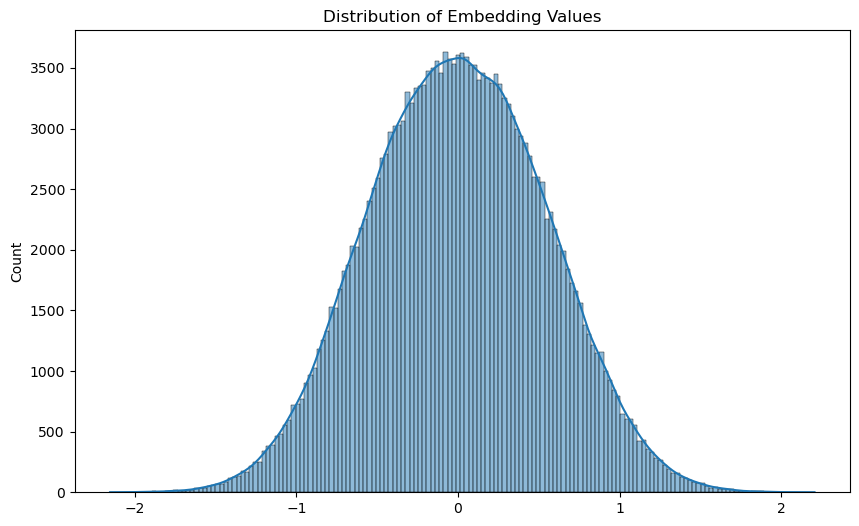

Best HDBSCAN parameters: {'min_cluster_size': 2, 'min_samples': 1, 'cluster_selection_epsilon': 0.0}
Best silhouette score: 0.3339910963235257


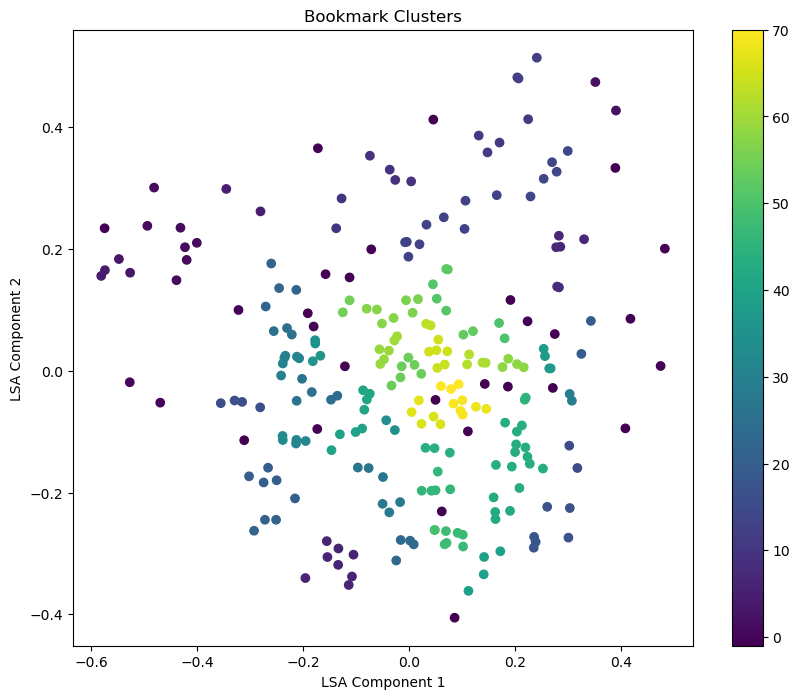

Clustered Bookmarks:
{
  "name": "Root",
  "type": "folder",
  "children": [
    {
      "name": "Folder 258.0",
      "type": "folder",
      "children": [
        {
          "name": "Folder 259.0",
          "type": "folder",
          "children": [
            {
              "name": "Folder 25.0",
              "type": "folder",
              "children": [
                {
                  "name": "Amazon Music Unlimited | Stream 100 Million Songs & Podcasts",
                  "type": "bookmark",
                  "url": "https://music.amazon.com/?_encoding=UTF8&ref=dm_ws_lnd_ups_hf_wp_xx_489408742"
                },
                {
                  "name": "LPT: How to get more out of Google - Imgur",
                  "type": "bookmark",
                  "url": "https://imgur.com/lpt-how-to-get-more-out-of-google-hkmIT"
                },
                {
                  "name": "Drowning in Problems",
                  "type": "bookmark",
                  "url": "ht

In [8]:
# Load the embedded bookmarks
with open('embedded_bookmarks.json') as f:
    data = json.load(f)

# Perform clustering
result = cluster_bookmarks(data)
parsed_result = json.loads(result)

# Display results
print("Clustered Bookmarks:")
print(json.dumps(parsed_result["folder_structure"], indent=2))
print("\nSilhouette Score:", parsed_result["silhouette_score"])
print("Best HDBSCAN Parameters:", parsed_result["best_params"])

## Analysis and Conclusions

In this section, you can add your observations about the clustering results, discuss the effectiveness of the LSA and HDBSCAN approach, and suggest potential improvements or next steps.